In [1]:
import numpy as np
import keras
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

2022-09-23 06:47:51.015408: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-23 06:47:51.015463: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Set random state

np.random.seed(20)

In [3]:
# Load the data

train_raw = loadmat('dataset/train_32x32.mat')
test_raw = loadmat('dataset/test_32x32.mat')

In [ ]:
test_raw

In [4]:
# Load images and labels

train_images = np.array(train_raw['X'])
test_images = np.array(test_raw['X'])

train_labels = train_raw['y']
test_labels = test_raw['y']

In [5]:
# Check the shape of the data

print(train_images.shape)
print(test_images.shape)

(32, 32, 3, 73257)
(32, 32, 3, 26032)


In [6]:
# Fix the axes of the images

train_images = np.moveaxis(train_images, -1, 0)
test_images = np.moveaxis(test_images, -1, 0)

print(train_images.shape)
print(test_images.shape)

(73257, 32, 32, 3)
(26032, 32, 32, 3)


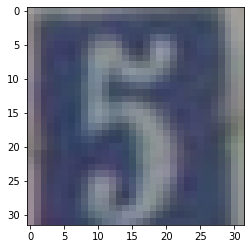

Label:  [5]


In [7]:
# Plot a random image and its label

plt.imshow(train_images[13529])
plt.show()

print('Label: ', train_labels[13529])

In [8]:
# Convert train and test images into 'float64' type

train_images = train_images.astype('float64')
test_images = test_images.astype('float64')

In [9]:
# Convert train and test labels into 'int64' type

train_labels = train_labels.astype('int64')
test_labels = test_labels.astype('int64')

In [10]:
# Normalize the images data

print('Min: {}, Max: {}'.format(train_images.min(), train_images.max()))

train_images /= 255.0
test_images /= 255.0

Min: 0.0, Max: 255.0


In [11]:
# One-hot encoding of train and test labels

lb = LabelBinarizer()
train_labels = lb.fit_transform(train_labels)
test_labels = lb.fit_transform(test_labels)

In [12]:
# Split train data into train and validation sets

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels,
                                                  test_size=0.15, random_state=22)

In [13]:
y_val.shape

(10989, 10)

In [14]:
# Data augmentation

datagen = ImageDataGenerator(rotation_range=8,
                             zoom_range=[0.95, 1.05],
                             height_shift_range=0.10,
                             shear_range=0.15)

In [15]:
# Define auxillary model

keras.backend.clear_session()

aux_model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), padding='same', 
                           activation='relu',
                           input_shape=(32, 32, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, (3, 3), padding='same', 
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(64, (3, 3), padding='same', 
                           activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3, 3), padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(128, (3, 3), padding='same', 
                           activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3, 3), padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.4),    
    keras.layers.Dense(10,  activation='softmax')
])

lr_schedule = keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
optimizer = keras.optimizers.Adam(learning_rate=1e-4, amsgrad=True)
aux_model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                 metrics=['accuracy'])

2022-09-23 06:48:11.518594: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-23 06:48:11.518651: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-23 06:48:11.518678: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (addin-gurihmas-dev): /proc/driver/nvidia/version does not exist
2022-09-23 06:48:11.541658: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
# Fit model in order to determine best learning rate

# history = aux_model.fit(datagen.flow(X_train, y_train, batch_size=128),
#                               epochs=30, validation_data=(X_val, y_val),
#                               callbacks=[lr_schedule])

In [17]:
# # Plot Learning Rate vs. Loss

# plt.semilogx(history.history['lr'], history.history['loss'])
# plt.axis([1e-4, 1e-1, 0, 4])
# plt.xlabel('Learning Rate')
# plt.ylabel('Training Loss')
# plt.show()

In [18]:
# Define actual model

keras.backend.clear_session()

model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), padding='same', 
                           activation='relu',
                           input_shape=(32, 32, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, (3, 3), padding='same', 
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(64, (3, 3), padding='same', 
                           activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3, 3), padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(128, (3, 3), padding='same', 
                           activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3, 3), padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.4),    
    keras.layers.Dense(10,  activation='softmax')
])

early_stopping = keras.callbacks.EarlyStopping(patience=8)
optimizer = keras.optimizers.Adam(learning_rate=1e-3, amsgrad=True)
model_checkpoint = keras.callbacks.ModelCheckpoint(
                   'best_cnn.h5', 
                   save_best_only=True)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
model.summary

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7f21c747bb10>>

In [20]:
# Fit model in order to make predictions

history = model.fit(datagen.flow(X_train, y_train, batch_size=128),
                              epochs=70, validation_data=(X_val, y_val),
                              callbacks=[early_stopping, model_checkpoint])

Epoch 1/70
487/487 [==============================] - 275s 562ms/step - loss: 2.1798 - accuracy: 0.2019 - val_loss: 1.9371 - val_accuracy: 0.3147
Epoch 2/70
487/487 [==============================] - 274s 563ms/step - loss: 1.5952 - accuracy: 0.4197 - val_loss: 1.0137 - val_accuracy: 0.6840
Epoch 3/70
487/487 [==============================] - 273s 560ms/step - loss: 1.0021 - accuracy: 0.6480 - val_loss: 0.4401 - val_accuracy: 0.8741
Epoch 4/70
487/487 [==============================] - 273s 561ms/step - loss: 0.5698 - accuracy: 0.8320 - val_loss: 0.2998 - val_accuracy: 0.9159
Epoch 5/70
487/487 [==============================] - 271s 556ms/step - loss: 0.4366 - accuracy: 0.8755 - val_loss: 0.2722 - val_accuracy: 0.9237
Epoch 6/70
487/487 [==============================] - 273s 561ms/step - loss: 0.3872 - accuracy: 0.8892 - val_loss: 0.2547 - val_accuracy: 0.9298
Epoch 7/70
487/487 [==============================] - 275s 564ms/step - loss: 0.3567 - accuracy: 0.8984 - val_loss: 0.2601 -

In [21]:
# Evaluate train and validation accuracies and losses

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

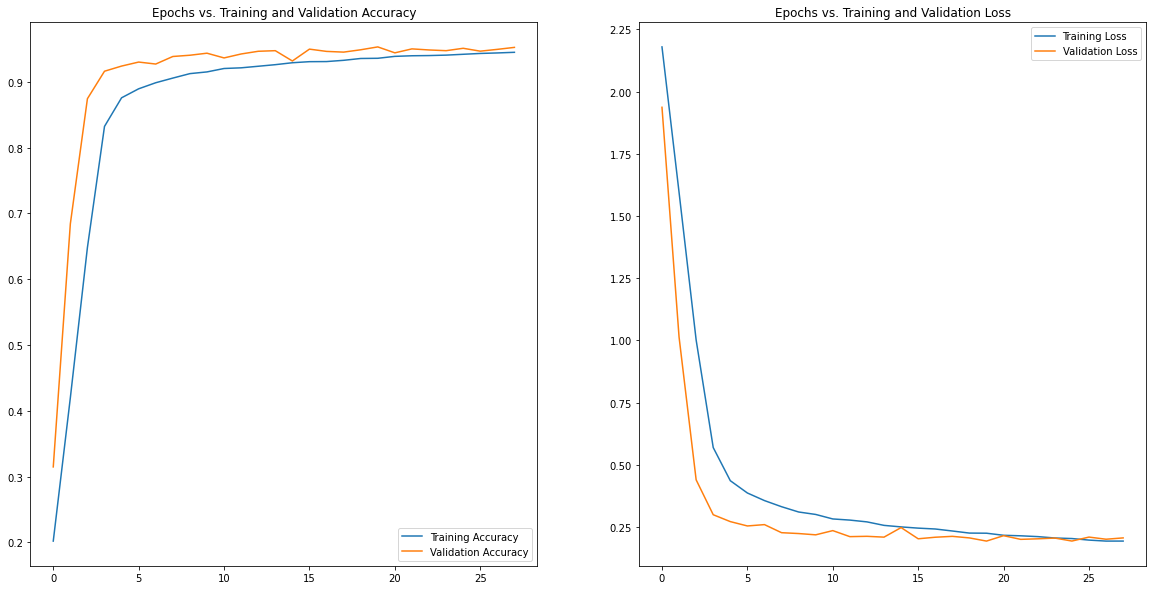

In [22]:
# Visualize epochs vs. train and validation accuracies and losses

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Epochs vs. Training and Validation Accuracy')
    
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Epochs vs. Training and Validation Loss')

plt.show()

In [23]:
# Evaluate model on test data
test_loss, test_acc = model.evaluate(x=test_images, y=test_labels, verbose=0)

print('Test accuracy is: {:0.4f} \nTest loss is: {:0.4f}'.
      format(test_acc, test_loss))

Test accuracy is: 0.9571 
Test loss is: 0.1787


In [24]:
# Get predictions and apply inverse transformation to the labels

y_pred = model.predict(X_train)

y_pred = lb.inverse_transform(y_pred, lb.classes_)
y_train = lb.inverse_transform(y_train, lb.classes_)

1946/1946 [==============================] - 66s 34ms/step


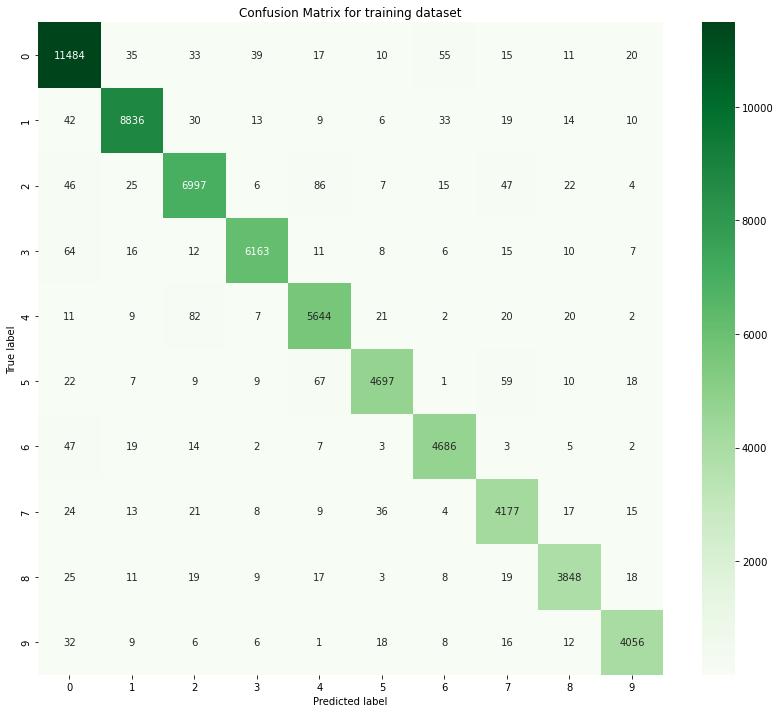

In [25]:
# Plot the confusion matrix

matrix = confusion_matrix(y_train, y_pred, labels=lb.classes_)

fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(matrix, annot=True, cmap='Greens', fmt='d', ax=ax)
plt.title('Confusion Matrix for training dataset')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [26]:
model.save("SVHNmodel.h5")